In [1]:
%matplotlib notebook
import cv2
import numpy as np
from localBlur.likematlab import im2col, EM_GMM
import matplotlib.pyplot as plt
from scipy import stats

### 이미지를 흑백으로 변환

In [2]:
img = cv2.imread('../image/out_of_focus0015.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img.astype('double'), None, 0.0, 1.0, cv2.NORM_MINMAX)

In [3]:
patchsize = 11

### localBlurScore 부분

In [4]:
im_height, im_width = img.shape
offset = int((patchsize -1)/2)
x_start = offset+1; x_end = im_width-offset;
y_start = offset+1; y_end = im_height-offset;
datasize = (x_end-x_start+1)*(y_end-y_start+1)

### LocalKurtosis.m 부분 [수정]

#### Image gradient 계산

In [22]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

#### patch에 따라 column으로 나열

In [23]:
sobelx_col = im2col(sobelx,[patchsize,patchsize])
sums_dx_col = np.sum(sobelx_col,0,keepdims=True)
sums_dx_col[sums_dx_col == 0] = np.nan
sobelx_col = sobelx_col / sums_dx_col

In [21]:
sobely_col = im2col(sobely,[patchsize,patchsize])
sums_dy_col = np.sum(sobely_col,0,keepdims=True)
sums_dy_col[sums_dy_col == 0] = np.nan
sobely_col = sobely_col / sums_dy_col

#### kurtosis 계산

In [55]:
dx_kurtosis = stats.kurtosis(sobelx_col,axis=0,fisher=False)
dy_kurtosis = stats.kurtosis(sobely_col,axis=0,fisher=False)

#### 결과를 이미지 형태로 reshape

In [56]:
dx_kurtosis = np.reshape(dx_kurtosis, [im_width-patchsize+1, im_height-patchsize+1])
dy_kurtosis = np.reshape(dy_kurtosis, [im_width-patchsize+1, im_height-patchsize+1])

In [57]:
dx_kurtosis = np.log(np.pad(dx_kurtosis,offset,mode='edge'))
dy_kurtosis = np.log(np.pad(dy_kurtosis,offset,mode='edge'))

In [58]:
img_kurtosis = np.transpose(np.minimum(dx_kurtosis,dy_kurtosis))

C:\Users\sangjaekang123\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in minimum
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


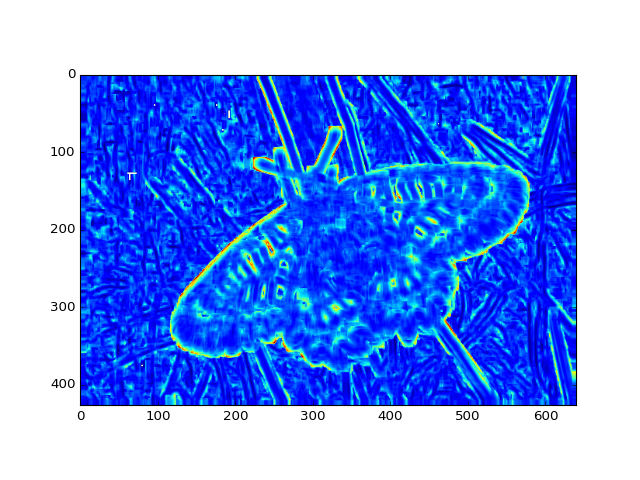

In [59]:
plt.imshow(img_kurtosis)

### LocalKurtosis.m 부분

[numpy vs matlab diff 출처](https://stackoverflow.com/questions/39410096/matlab-difff-var-n-vs-python-numpy-diffa-n-1-axis-1)

In [5]:
dx = np.c_[np.diff(img,axis=1),-img[:,-1]]
dy = np.r_['0,2',np.diff(img,axis=0),-img[-1,:]]

In [15]:
dx_col = im2col(dx,[patchsize,patchsize])
sum_dx_col = np.sum(dx_col,1,keepdims=True)
sum_dx_col[sum_dx_col == 0] = np.nan
dx_col = dx_col / sum_dx_col

In [ ]:
dy_col = im2col(dy,[patchsize,patchsize])
sum_dy_col = np.sum(dy_col,0,keepdims=True)
sum_dy_col[sum_dy_col == 0] = np.nan
dy_col = dy_col / sum_dy_col

In [ ]:
normXsquare = np.square(dx_col - np.mean(dx_col,0))
normYsquare = np.square(dy_col - np.mean(dy_col,0))

In [ ]:
mean_square_x = np.square(np.mean(normXsquare,axis=0,keepdims=True))
mean_square_x[mean_square_x==0] = np.nan
qx = np.mean(np.square(normXsquare),axis=0,keepdims=True) / mean_square_x
mean_square_y = np.square(np.mean(normYsquare,axis=0,keepdims=True))
mean_square_y[mean_square_y==0] = np.nan
qy = np.mean(np.square(normYsquare),axis=0,keepdims=True) / mean_square_y

In [ ]:
qx = np.reshape(qx, [im_width-patchsize+1, im_height-patchsize+1])
qy = np.reshape(qy, [im_width-patchsize+1, im_height-patchsize+1])

In [ ]:
qx[qx==0] = np.nan
qx = np.log(np.pad(qx,offset,mode='edge'))
qy[qy==0] = np.nan
qy = np.log(np.pad(qy,offset,mode='edge'))

In [ ]:
qx[np.isnan(qx)] = np.min(np.min(qx[~np.isnan(qx)]))
qy[np.isnan(qy)] = np.min(np.min(qy[~np.isnan(qy)]))

In [ ]:
q = np.minimum(qx,qy)

In [ ]:
plt.imshow(img,cmap='gray')

In [ ]:
q = np.transpose(q)
plt.imshow(q,cmap='gray')

### LocalPowerSpectrumSlope

In [ ]:
from localBlur import likematlab

In [ ]:
im_height, im_width = img.shape
offset = (patchsize - 1)/2

In [ ]:
def GenerateF(height,width):
    kheight = range(1,int(height)+1)
    kwidth  = range(1,int(width)+1)
    [u,v] = np.meshgrid(kwidth,kheight)
    f = np.hypot(u, v)
    C = np.unique(f)
    f = np.round(f)
    return (f,C)

In [ ]:
[If, IC] = GenerateF(offset,offset)
IC_log = np.log(IC)
IC_log_new = np.unique(np.round(IC_log / 0.2)*0.2)

In [ ]:
im_col = likematlab.im2col(img, [patchsize,patchsize])
im_col = im_col / np.sum(im_col,1,keepdims=True)
q = np.zeros((1,im_col.shape[1]))

In [ ]:
lsf = GenerateSf(np.reshape(im_col[:,0], [patchsize,patchsize]),If,IC, offset,offset)

In [ ]:
lsf

In [ ]:
for i in range(im_col.shape[1]):
    lsf = GenerateSf(np.reshape(im_col[:,i], [patchsize,patchsize]),If,IC, offset,offset)
    

In [ ]:
def GenerateSf(im, f, C, half_height, half_width):
    # Power Spectrum Slope
    height, width = im.shape
    s = (np.abs(np.fft.fft2(im,(height,width))))
    s = np.square(s[0:int(half_height),0:int(half_width)])/int(half_height*half_width)
    #sf = calculateSf(s,C,f)
    return s

In [ ]:
def calculateSf(s,C,f):
    sf = np.zeros(C.shape)
    s = s.flatten()
    for i in range(sf.size):
        cnt = 0 
        for j in range(s.size):
            if (f[j]==C[i]) :
                sf[i] += s[j]
                cnt += 1
        sf[i] /= cnt
    return sf
            

In [ ]:
sf = np.array([[1,2,3],[4,5,6]])
sf.flatten()